In [ ]:
# ML Project
# Group 15 
# Akshat Saini - 2020019
# Nakul Thureja - 2020528
# Nishaant Rastogi - 2020091

In [ ]:
! pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from pathlib import Path
import pickle
import os
import requests
import zipfile
import gzip
import ast
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
import os
import pickle
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, optimizers, losses, metrics, regularizers, callbacks

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ML_Project_Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate = 100
data_folder = path

In [ ]:
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [ ]:
# Load raw signal data
if os.path.isfile('/content/drive/MyDrive/PTB-XL/X.pkl') == False:
  X = load_raw_data(Y, sampling_rate, path)
  pickle.dump(X, open('/content/drive/MyDrive/PTB-XL/X.pkl', 'wb'))
else:
  X = pickle.load(open('/content/drive/MyDrive/PTB-XL/X.pkl', 'rb'))

In [ ]:
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)


In [ ]:
agg_df = agg_df[agg_df.diagnostic == 1]


In [ ]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [ ]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [ ]:
Y.columns


Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL',
       'diagnostic_superclass'],
      dtype='object')

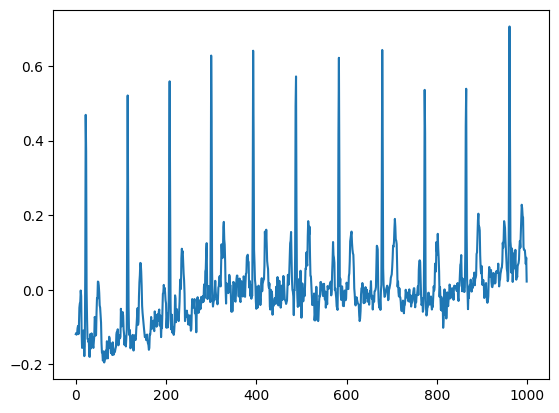

In [ ]:
plt.plot(X[0][:,0])
plt.show()

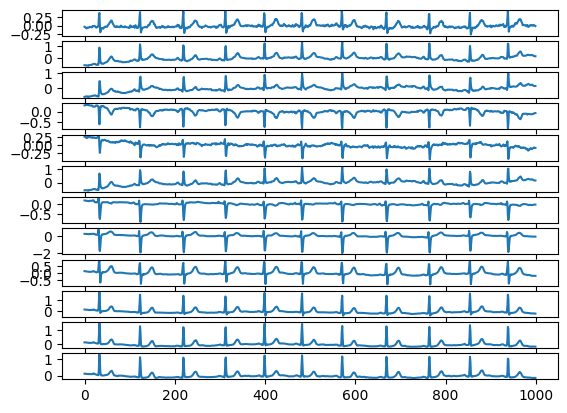

In [ ]:
ecg = X[4]
plt.figure()
for index in range(12):
    plt.subplot(12,1,index+1)
    plt.plot(ecg[:,index])
plt.show()


In [ ]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

In [ ]:
ecg_original = X[np.random.randint(3096)][:,0]
ecg_filtered = np_move_avg(ecg_original, 5)

In [ ]:
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs,
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg


In [ ]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

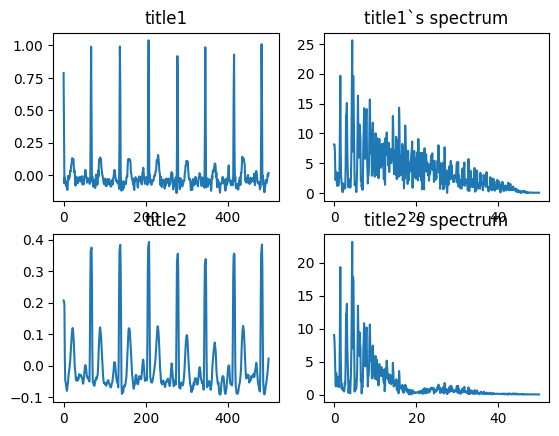

In [ ]:
show_spec_dif(ecg_original, ecg_filtered)


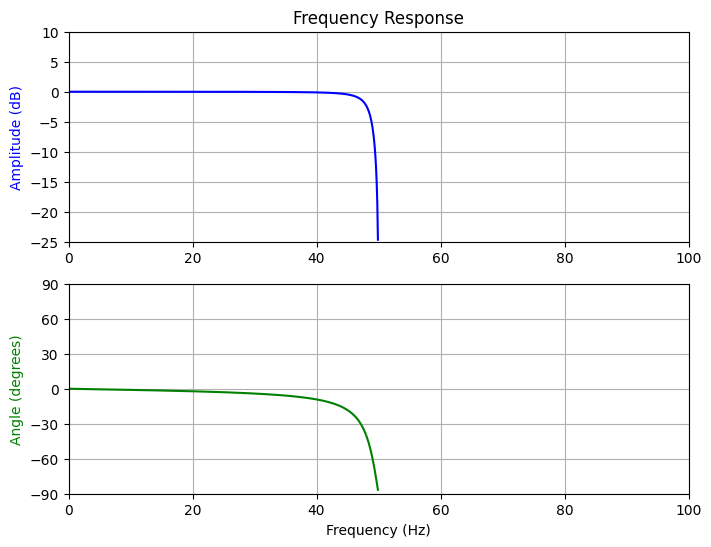

In [ ]:
fs = sampling_rate  
f0 = 50.0   
Q = 30.0    
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [ ]:
ecg_notch = signal.filtfilt(b, a, ecg_filtered)


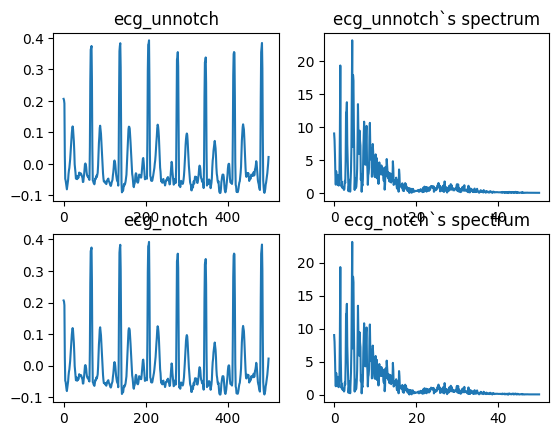

In [ ]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")


In [ ]:
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

In [ ]:
ecg = X[np.random.randint(len(X))][:,1]


In [ ]:
def get_diff(ecg):
    ecg_diff = np.zeros(len(ecg))
    for i in range(len(ecg)-1):
        ecg_diff[i] = ecg[i+1] - ecg[i]
    ecg_diff[len(ecg)-1] = ecg[len(ecg)-1]
    return ecg_diff

In [ ]:
def checkR(ecg):
    max_val = np.max(ecg)
    min_val = np.min(ecg)
    threshold_val = (max_val-min_val)*0.7 + min_val
    index = []
    for i in range(1, len(ecg)-2):
        if ecg[i] == np.max(ecg[i-1:i+2]) and ecg[i] > threshold_val:
            if index != []:
                if i-index[-1] <= 60.0/60.0*sampling_rate and i-index[-1] >= 60.0/160.0*sampling_rate:
                    index.append(i)
            else:
                index.append(i)
    return np.array(index)

In [ ]:
index = checkR(ecg)

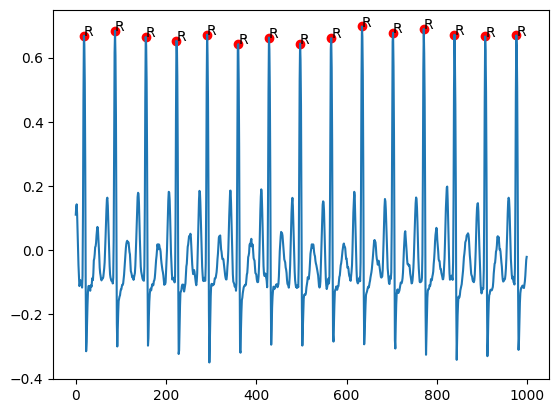

In [ ]:
plt.figure()
plt.plot(ecg)
for i in range(len(index)):
    plt.scatter(index[i], ecg[index[i]],c='r')
    plt.annotate('R',(index[i], ecg[index[i]]))
plt.show()


In [ ]:
def splitByR(ecg):
    index = checkR(ecg)              
    ecg_rhythm = None
    for i in range(len(index)):
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-150:index[i]+350]
            continue
    return ecg_rhythm

In [ ]:
ecg_rhythm = splitByR(ecg)
print(ecg_rhythm)

[-1.880e-02 -6.660e-02 -9.400e-02 -1.062e-01 -1.150e-01 -1.140e-01
 -1.178e-01 -1.092e-01 -1.108e-01 -1.152e-01 -3.520e-02  2.192e-01
  5.276e-01  6.430e-01  5.930e-01  4.522e-01  1.554e-01 -1.802e-01
 -2.970e-01 -2.482e-01 -1.940e-01 -1.522e-01 -1.390e-01 -1.384e-01
 -1.372e-01 -1.384e-01 -1.322e-01 -1.164e-01 -1.078e-01 -9.800e-02
 -8.400e-02 -8.720e-02 -9.020e-02 -7.920e-02 -6.280e-02 -3.580e-02
 -1.100e-02 -1.200e-03  8.200e-03  1.820e-02  9.400e-03  8.200e-03
  1.800e-02  1.060e-02 -5.600e-03 -1.420e-02 -1.880e-02 -3.320e-02
 -4.140e-02 -4.660e-02 -5.340e-02 -6.180e-02 -7.140e-02 -7.880e-02
 -9.820e-02 -1.132e-01 -1.162e-01 -1.140e-01 -9.700e-02 -5.000e-02
 -3.400e-03  3.560e-02  9.660e-02  1.412e-01  1.522e-01  1.494e-01
  1.226e-01  6.300e-02  5.600e-03 -4.380e-02 -8.880e-02 -1.102e-01
 -1.210e-01 -1.150e-01 -1.070e-01 -9.540e-02 -8.800e-02 -1.036e-01
 -8.280e-02  7.400e-02  3.866e-01  6.266e-01  6.602e-01  5.674e-01
  3.436e-01 -7.800e-03 -2.628e-01 -2.846e-01 -2.272e-01 -1.706

In [ ]:
ecg_rhythm.shape

(500,)

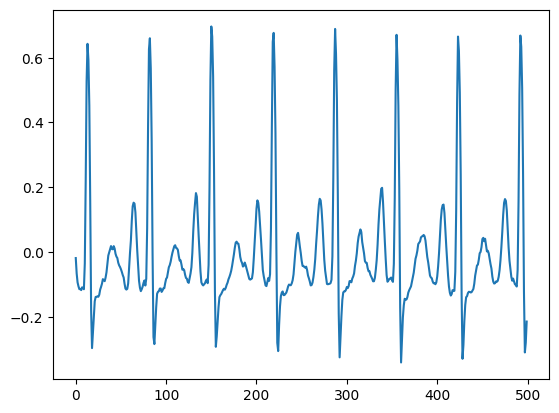

In [ ]:
plt.figure()
plt.plot(ecg_rhythm)
plt.show()

In [ ]:
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 500, 12])

start_time = time.time()
first_time = start_time
for index in range(test_size):
    R_index = checkR(X[index][:,1])
    for i in range(len(R_index)):
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

time cost:102 s


In [ ]:
ecg_rhythms.shape


(21801, 500, 12)

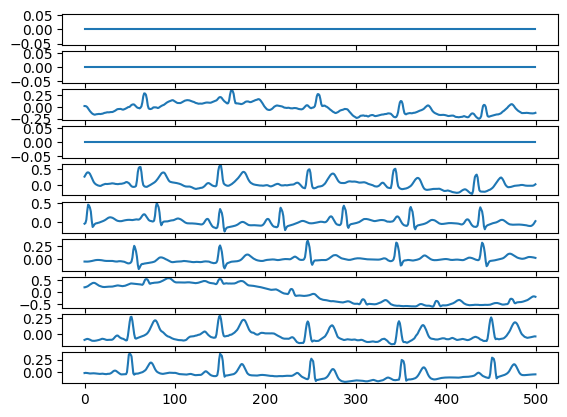

In [ ]:
plt.figure()
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(ecg_rhythms[i][:,1])
plt.show()


In [ ]:
false_count = 0
Y['Runconfirmed'] = 0
for index in range(len(ecg_rhythms)):
    if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
        false_count += 1
        Y['Runconfirmed'][index] = 1
false_count

<ipython-input-35-3e2619af43cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
<ipython-input-35-3e2619af43cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
<ipython-input-35-3e2619af43cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1
<ipython-input-35-3e2619af43cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

6236

In [ ]:
X = ecg_rhythms

In [ ]:
y = np.asarray(Y.diagnostic_superclass)

In [ ]:
X.shape

(21801, 500, 12)

In [ ]:
pickle.dump(X,open('/content/drive/MyDrive/PTB-XL/X_ecg.pkl', 'wb'))
pickle.dump(y,open('/content/drive/MyDrive/PTB-XL/y_ecg.pkl', 'wb'))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

In [ ]:
for index in range(len(y_train)):
    try:
        y_train[index] = np.where(num2class == y[index][0])[0][0]    
    except:
        y_train[index] = np.where(num2class == 'NORM')[0][0]


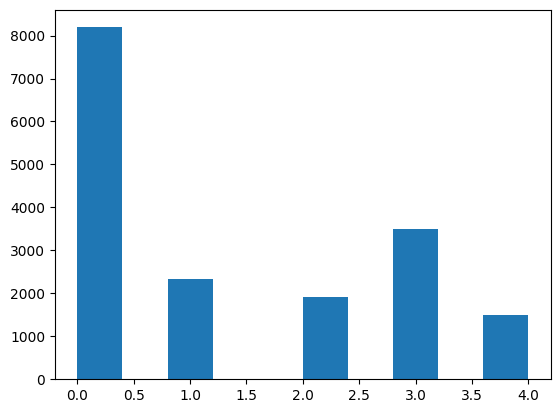

In [ ]:
plt.hist(y_train)
plt.show()


In [ ]:
for index in range(len(y_test)):
    try:
        y_test[index] = np.where(num2class == y_test[index][0])[0][0]
    except:
        y_test[index] = np.where(num2class == 'NORM')[0][0]


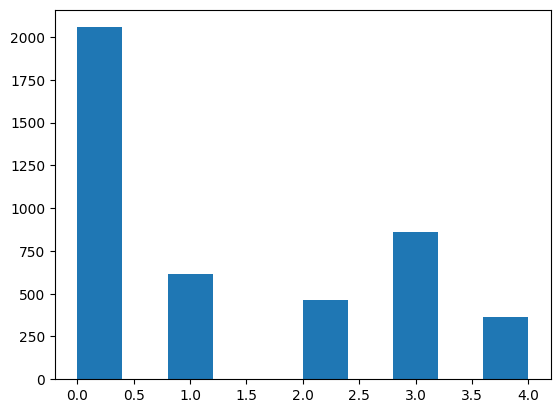

In [ ]:
plt.hist(y_test)
plt.show()


In [ ]:
y_train = y_train.reshape(1, -1)[0].astype('uint8')
y_test = y_test.reshape(1, -1)[0].astype('uint8')

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
oversampler = SMOTE(random_state=42)

os_features, os_label = oversampler.fit_resample(X_train.reshape(len(X_train), 6000), y_train)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_train = PCA(n_components=240)
pca_train.fit(os_features)

PCA(n_components=240)

In [ ]:
X_train_pca = pca_train.fit_transform(os_features)

In [ ]:
pca_train.explained_variance_ratio_.sum()

0.8964591592871143

In [ ]:
X_test_flatten = X_test.reshape(len(X_test), 6000)
pca_test = PCA(n_components=240)
pca_test = PCA(X_test_flatten)

In [ ]:
X_test_pca = pca_train.fit_transform(X_test_flatten)

In [ ]:
pickle.dump(X_test_pca,open('/content/drive/MyDrive/PTB-XL/X_test_pca.pkl', 'wb'))
pickle.dump(y_test,open('/content/drive/MyDrive/PTB-XL/y_test_pca.pkl', 'wb'))
pickle.dump(X_train_pca,open('/content/drive/MyDrive/PTB-XL/X_train_pca.pkl', 'wb'))
pickle.dump(os_label,open('/content/drive/MyDrive/PTB-XL/y_train_pca.pkl', 'wb'))

In [ ]:
X_test_pca.shape,y_test.shape

((4361, 240), (4361,))

In [ ]:
X_train_pca.shape,os_label.shape

((40965, 240), (40965,))